# Evaluate Distortions 


***Created on 04/16/2023***

***@author: jane***


This notebook reproduces our "hold-one-contorl-out" experiment, which aims to evaluate the extent of distortion introduced during integration. The data we use for this tutorial is from a type 1 diabetes by [***Maria Fasolino et al. (2022)***](https://www.nature.com/articles/s42255-022-00531-x), and it can be downloaded from [here](https://cellxgene.cziscience.com/collections/51544e44-293b-4c2b-8c26-560678423380). We have subsampled 20,000 cells for illustration purposes.

In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import harmonypy as hm
import scanpy.external as sce
from scipy import stats


sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80)
pd.set_option('display.max_columns', None)
seed = 10
np.random.seed(seed)

We consider two types of distortions:
1. Global distortion: the degree to which the integrated data differs from the true expression profiles of each individual cell. Excessive global distortion can lead to inaccurate downstream analyses and misinterpretation of biological findings. 
2. Gene-level signal distortion: the preservation of gene-level differences (or the lack thereof) between predefined cell groups. The concern here is that integration may artificially strengthen or weaken differential expression signals between cell groups.

Evaluation method: 
1. To assess the global distortion, we computed the correlation of the expression between before and after correction for each cell in the holdout sample. A high correlation indicates minor global distortions. 
2. To assess gene-level signal distortions, we first held out one sample and fitted the model with the remaining samples. 
  - Before batch correction, we identified differentially expressed genes between cell types within the holdout sample using the Wilcoxon signed-rank test and obtained p-values for each gene, adjusted for multiple testing. 
  - We then predicted batch-corrected expressions for the holdout sample using the fitted model and performed differential expression analysis between cell types, again obtaining adjusted p-values for each gene. 
  - Finally, we compared the two sets of p-values, with a high correlation indicating minimal gene-wise distortions.



## 1. Load data, preprocess

Now we load data and we only take control samples from this dataset to perform experiment. 

In [2]:
adata = sc.read_h5ad('t1d_example.h5ad')
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[adata.obs['PseudoState']=='Control',]

In [3]:
integrate_key='dataidx'

Next, we perform library size normalization, log1p transform, highly variable genes selection, and per gene standardization. This is the standard preprocessing implemented in the function `preprocess_data`. We save the log1p transformed data for harmony integration and symphony mapping.

In [4]:
adata_prep = cnova.model.preprocess_data(adata, integrate_key=integrate_key)

expr_df = pd.DataFrame(data = adata_prep.layers['lognorm'], 
                       index = adata_prep.obs_names,
                       columns = adata_prep.var_names)
meta_df = adata_prep.obs
expr_df.to_csv("expr_norm.csv")
meta_df.to_csv("meta.csv")

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Choose one sample as the holdout validation

In [5]:
holdout_idx = ['HPAP036']
adata_prep.obs['Experiment Group'] = np.where(adata_prep.obs['dataidx'].isin(holdout_idx), 'holdout', 'train')
adata_prep.obs

,dataidx,celltype,disease_state,celltype_orig,donor_id,disease,assay,sex,ethnicity,development_stage,PseudoState,n_genes,Experiment Group
GTGCAGCGTCCAGTGC-1,HPAP022,delta,Control,pancreatic D cell,HPAP022,normal,10x 3' v2,female,European,39,Control,4701,train
ACTTACTGTCTCAACA-1,HPAP022,delta,Control,pancreatic D cell,HPAP022,normal,10x 3' v2,female,European,39,Control,3932,train
GCACTCTGTCTTCGTC-1,HPAP022,alpha,Control,pancreatic A cell,HPAP022,normal,10x 3' v2,female,European,39,Control,5243,train
ACATGGTTCTGGTGTA-1,HPAP022,alpha,Control,pancreatic A cell,HPAP022,normal,10x 3' v2,female,European,39,Control,3317,train
CCTAAAGTCCGCAAGC-1,HPAP022,alpha,Control,pancreatic A cell,HPAP022,normal,10x 3' v2,female,European,39,Control,582,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCATAAGTCCAGCACG-11,HPAP047,duct_acinar_related,Control,pancreatic ductal cell,HPAP047,normal,10x 3' v3,male,European,8,Control,2088,train
CGTGATATCTGGTCAA-11,HPAP047,acinar,Control,pancreatic acinar cell,HPAP047,normal,10x 3' v3,male,European,8,Control,596,train
CCTCTCCGTTATGACC-11,HPAP047,pp,Control,PP cell,HPAP047,normal,10x 3' v3,male,European,8,Control,1209,train
AGTAGTCCATTCCTAT-11,HPAP047,acinar,Control,pancreatic acinar cell,HPAP047,normal,10x 3' v3,male,European,8,Control,405,train


## 2. Estimate cell states

Before moving to the next block, we first use 2 R packages harmony and symphony to estimate cell states. Run the following code in R. In this R code, we integrate all training samples and estimate cell states for the training samples. Then we use Symphony package mapping query (holdout sample) to reference (integrated training samples) in order to estimate cell states C for the holdout sample.

In [6]:
#library(symphony)
#library(harmony)
#library(irlba)
#library(tidyverse)
#library(data.table)
#library(matrixStats)
#library(Matrix)
#library(plyr)
#library(dplyr)
#
### Read in normalized expression and metadata
#exprs_norm = read.csv('expr_norm.csv', row.names = 1)
#metadata = read.csv('meta.csv', row.names = 1)
#exprs_norm = t(exprs_norm)
#exprs_norm <- as(exprs_norm, "sparseMatrix") 
#dim(exprs_norm)
#dim(metadata)
#
### Preprocess
#idx_query = which(metadata$dataidx == "HPAP036") # use HPAP036 sample as the query
#ref_exp_full = exprs_norm[, -idx_query]
#ref_metadata = metadata[-idx_query, ]
#query_exp = exprs_norm[, idx_query]
#query_metadata = metadata[idx_query, ]
#var_genes = rownames(ref_exp_full)
#ref_exp = ref_exp_full[var_genes, ]
#rm(ref_exp_full)
#vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
#vargenes_means_sds$stddev = rowSDs(ref_exp, vargenes_means_sds$mean)
#ref_exp_scaled = scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)
#
### Run SVD, and Harmony integration
#set.seed(0)
#s = irlba(ref_exp_scaled, nv = 70)
#Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
#loadings = s$u
#save_11 = s
#ref_harmObj = harmony::HarmonyMatrix(
#  data_mat = t(Z_pca_ref),  
#  meta_data = ref_metadata, 
#  theta = c(2),             
#  vars_use = c('dataidx'),    
#  nclust = 100,             
#  max.iter.harmony = 30,
#  return_object = TRUE,     
#  do_pca = FALSE            
#)
#
### Run Symphony mapping
#reference = symphony::buildReferenceFromHarmonyObj(
#  ref_harmObj,            
#  ref_metadata,           
#  vargenes_means_sds,     
#  loadings,               
#  verbose = TRUE,         
#  do_umap = FALSE,         
#  save_uwot_path = './')
#query = mapQuery(query_exp,             
#                 query_metadata,        
#                 reference,             
#                 do_normalize = FALSE,  
#                 do_umap = FALSE)       
#reference$meta_data$ref_query = 'reference'
#query$meta_data$ref_query = 'query'
#
### Save results
#Z_orig_combined = rbind(t(query$Zq_pca), t(reference$Z_orig))
#Z_corr_combined = rbind(t(query$Z), t(reference$Z_corr))
#meta_data_combined = rbind(query$meta_data, reference$meta_data)
#rownames(loadings) = rownames(ref_exp_scaled)
#write.table(Z_corr_combined, file="symphony_Z_corr.txt", quote=F, sep='\t', row.names = T, col.names = T)
#write.table(loadings, file="symphony_loadings.txt", quote=F, sep='\t', row.names = T, col.names = T)
#write.table(meta_data_combined, file="symphony_meta.txt", quote=F, sep='\t', row.names = T, col.names = T)

Load estimated cell states.

In [7]:
Z_corr_combined = pd.read_csv('symphony_Z_corr.txt', header=0, index_col=0, sep='\t')
Z_corr_combined = Z_corr_combined.loc[adata_prep.obs_names]
print( np.all(Z_corr_combined.index == adata_prep.obs_names) )
adata_prep.obsm['Cmat'] = Z_corr_combined.to_numpy()

True


## 3. Fit model using training set

We first use training samples to estimate main effect by regression.

In [8]:
adata_train = adata_prep[~adata_prep.obs[integrate_key].isin(holdout_idx),]
adata_test = adata_prep[adata_prep.obs[integrate_key].isin(holdout_idx),]
print(adata_train.shape, adata_test.shape)

(7092, 3000) (539, 3000)


In [9]:
Mmat = cnova.model.fit_M(adata_train, integrate_key = integrate_key)
adata_train.varm['Mmat'] = Mmat.T

Now the control pool is just the set of all samples in the training set, we build a control dictionary as follows:

In [10]:
control_dict = {
    'g1': list(set(adata_train.obs[integrate_key])),
}
control_dict

{'g1': ['HPAP044',
  'HPAP047',
  'HPAP022',
  'HPAP039',
  'HPAP042',
  'HPAP040',
  'HPAP037',
  'HPAP035',
  'HPAP034',
  'HPAP026']}

We then use training set to estimate batch variation basis.

In [11]:
adata_train = cnova.model.calc_BE(adata_train, integrate_key, control_dict)
Vmat = adata_train.varm['V_BE_basis']
Vmat.shape

(3000, 454)

## 4. Predict corrected expression for both training and holdout set

We have fitted the model with training samples. Now we can apply the fitted model to both training data and holdout sample to predict the batch-corrected expression.

In [12]:
be = (adata_prep.layers['scale'] - adata_prep.obsm['Cmat'] @ Mmat) @ Vmat @ Vmat.T
adata_prep.layers['corrected'] = adata_prep.layers['scale'] - be

UMAP visualization for the cellanova-integrated data. Since the holdout sample mixed well with training samples, we believe samples in the control pool, namely training samples, have captured most batch variation modes. And our strategy (using control pool to remove batch effect for treatment samples) works in practice.

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


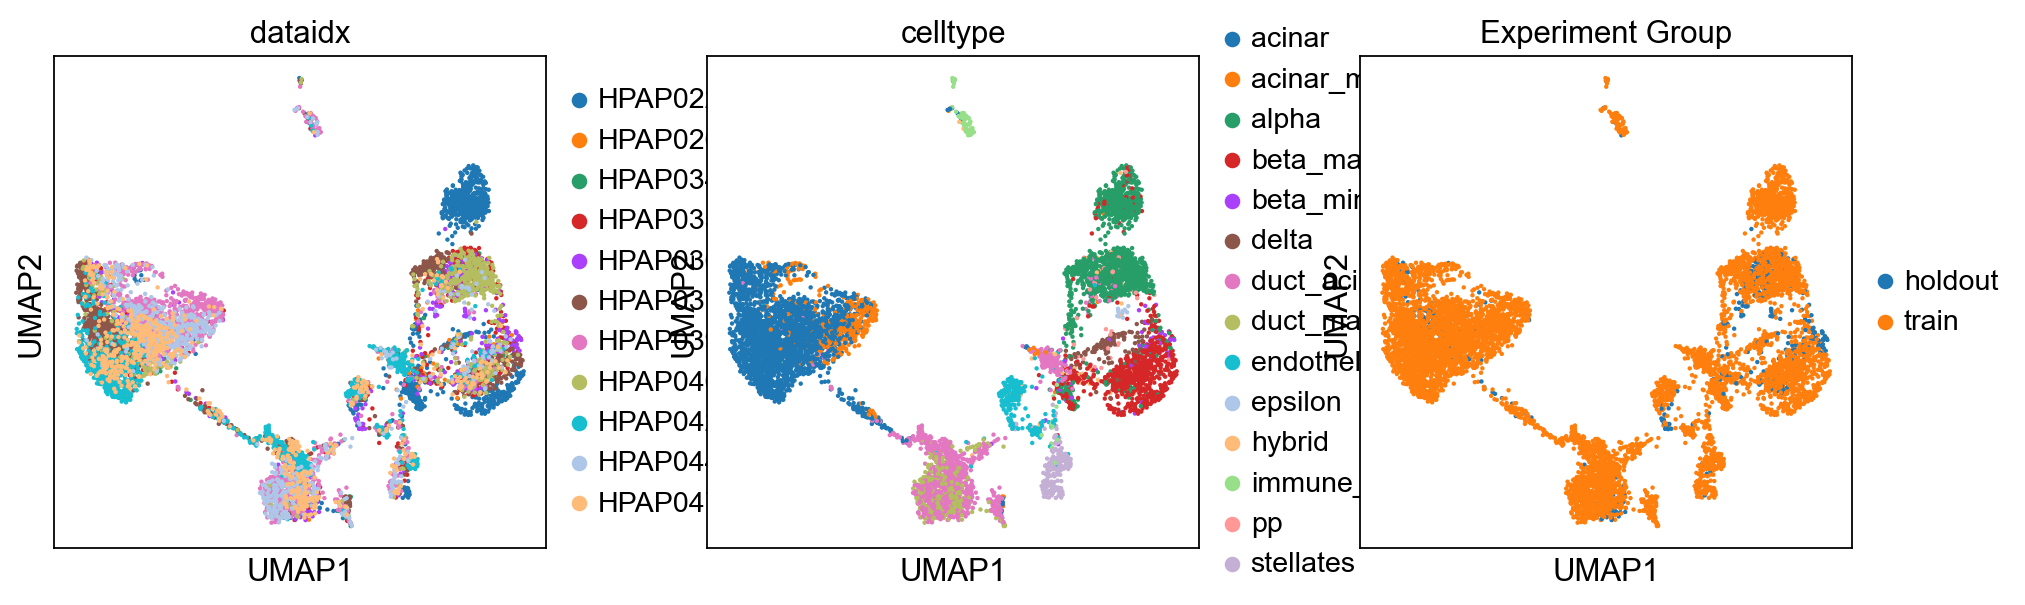

In [13]:
integrated = ad.AnnData(adata_prep.layers['corrected'], dtype = np.float32)
integrated.var_names = adata_prep.var_names
integrated.obs = adata_prep.obs.copy()
sc.pp.neighbors(integrated, n_neighbors=15, n_pcs=30)
sc.tl.umap(integrated)
sc.pl.umap(integrated, color=['dataidx','celltype','Experiment Group'])

We can also visualize symphony-integrated data as a comparison.

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


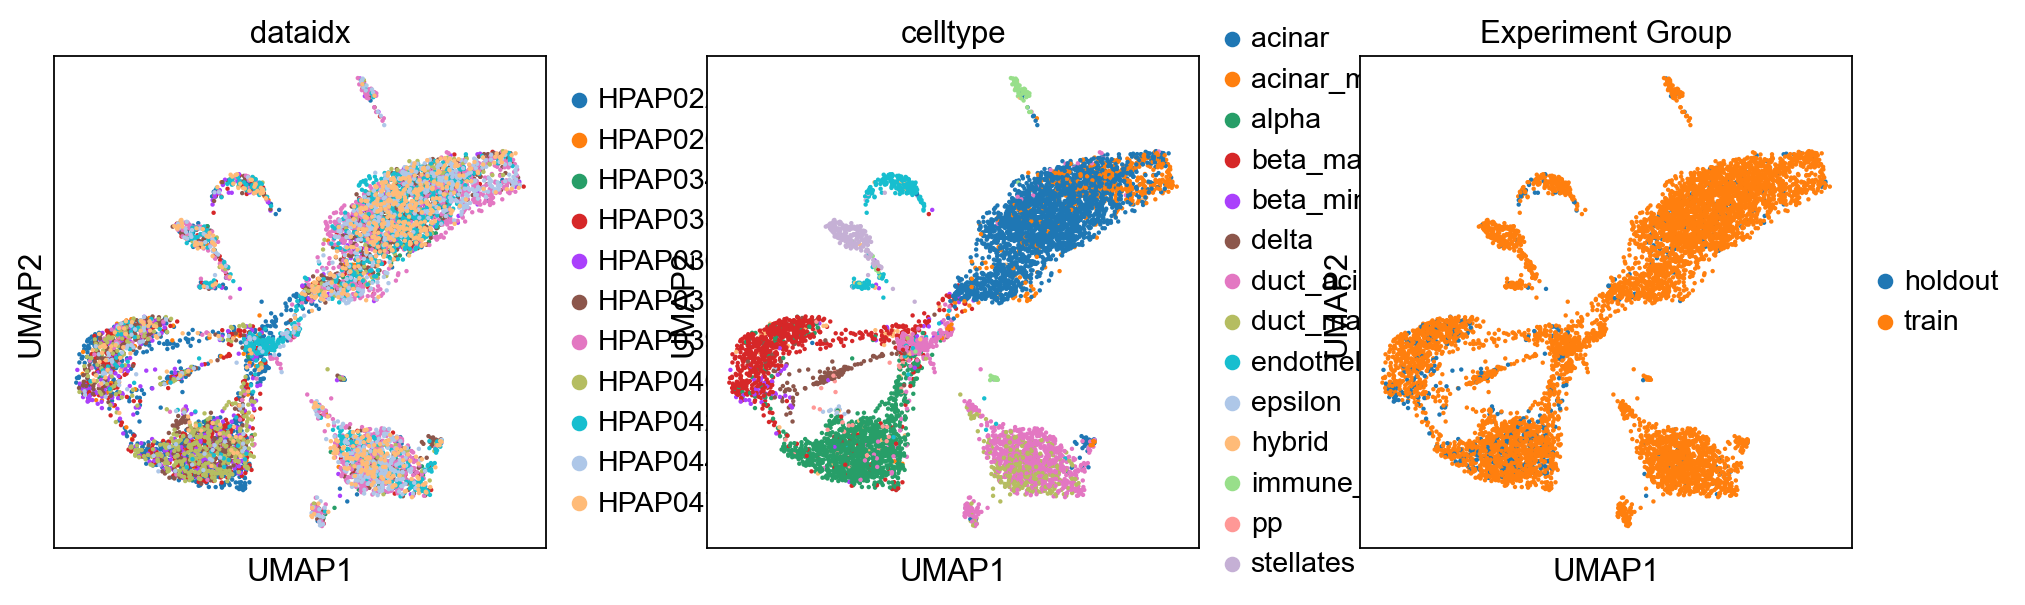

In [14]:
loadings = pd.read_csv('symphony_loadings.txt', header=0, index_col=0, sep='\t')
symphony_meta = pd.read_csv('symphony_meta.txt', header=0, index_col=0, sep='\t')
symphony = ad.AnnData(Z_corr_combined.to_numpy() @ loadings.to_numpy().T, dtype = np.float32)
symphony.var_names = adata_prep.var_names
symphony.obs = adata_prep.obs.copy()
sc.pp.neighbors(symphony, n_neighbors=15, n_pcs=30)
sc.tl.umap(symphony)
sc.pl.umap(symphony, color=['dataidx','celltype','Experiment Group'])

## 5. Evaluate global distortion

In [15]:
rowcorr1 = np.zeros(shape = (adata_prep.layers['scale'].shape[0],1))
for ii in range(adata_prep.layers['scale'].shape[0]):
    rowcorr1[ii,0] = np.corrcoef(symphony.X[ii,:], adata_prep.layers['scale'][ii,:])[0,1]
method1 = np.repeat("Symphony", rowcorr1.shape[0]).tolist()
    
rowcorr2 = np.zeros(shape = (adata_prep.layers['scale'].shape[0],1))
for ii in range(adata_prep.layers['scale'].shape[0]):
    rowcorr2[ii,0] = np.corrcoef(integrated.X[ii,:], adata_prep.layers['scale'][ii,:])[0,1]
method2 = np.repeat("CellANOVA", rowcorr2.shape[0]).tolist() 

In [16]:
corr_combined = rowcorr1.flatten().tolist() + rowcorr2.flatten().tolist()
method_combined = method1 + method2
data = {'Correlation': corr_combined,
        'Method': method_combined}
df = pd.DataFrame(data)

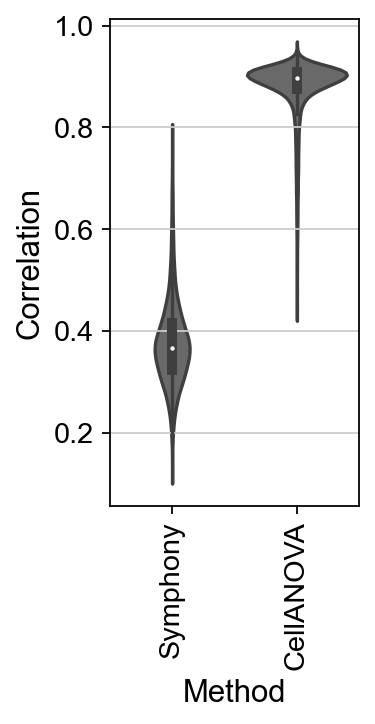

In [17]:
fig = plt.figure(figsize=(2, 4))
ax = sea.violinplot(x="Method", y="Correlation", data=df, color="dimgrey")
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel("Method", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)
plt.xticks(rotation=90)
plt.show()

As a conclusion, a higher correlation between pre- and post- correction cell profiles indicates minor global distortion.

## 6. Evaluate gene-level signal distortion

As an example, we compare beta major cells with the rest, within the holdout sample.

In [18]:
ct_tocompare = 'duct_major'
ct_reference = 'rest'
ct_key = 'celltype'

Perform DEG using uncorercted data, CellANOVA-corrected, Symphony-corrected, respectively.

In [19]:
adata_temp = integrated[integrated.obs['Experiment Group'].isin(['holdout'])]
sc.tl.rank_genes_groups(adata_temp, ct_key, 
                        groups=[ct_tocompare], reference=ct_reference, 
                        method='wilcoxon', key_added = "up_reg_wilcoxon")
d1 = {'gene_names': adata_temp.uns['up_reg_wilcoxon']['names'][ct_tocompare].tolist(),
      'scores': adata_temp.uns['up_reg_wilcoxon']['scores'][ct_tocompare].tolist(),
      'pvals_adj': adata_temp.uns['up_reg_wilcoxon']['pvals_adj'][ct_tocompare].tolist(),
      'data source': 'CellANOVA',}
df1 = pd.DataFrame(data=d1)
df1 = df1.rename(columns={"pvals_adj":"CellANOVA"})

adata_temp = symphony[symphony.obs['Experiment Group'].isin(['holdout'])]
sc.tl.rank_genes_groups(adata_temp, ct_key, 
                        groups=[ct_tocompare], reference=ct_reference, 
                        method='wilcoxon', key_added = "up_reg_wilcoxon")
d2 = {'gene_names': adata_temp.uns['up_reg_wilcoxon']['names'][ct_tocompare].tolist(),
      'scores': adata_temp.uns['up_reg_wilcoxon']['scores'][ct_tocompare].tolist(),
      'pvals_adj': adata_temp.uns['up_reg_wilcoxon']['pvals_adj'][ct_tocompare].tolist(),
      'data source': 'Symphony',}
df2 = pd.DataFrame(data=d2)
df2 = df2.rename(columns={"pvals_adj":"Symphony"})

uncorrected = ad.AnnData(adata_prep.layers['lognorm'], dtype = np.float32)
uncorrected.var_names = adata_prep.var_names
uncorrected.obs = adata_prep.obs.copy()
adata_temp = uncorrected[uncorrected.obs['Experiment Group'].isin(['holdout'])]
sc.tl.rank_genes_groups(adata_temp, ct_key, 
                        groups=[ct_tocompare], reference=ct_reference, 
                        method='wilcoxon', key_added = "up_reg_wilcoxon")
d3 = {'gene_names': adata_temp.uns['up_reg_wilcoxon']['names'][ct_tocompare].tolist(),
      'scores': adata_temp.uns['up_reg_wilcoxon']['scores'][ct_tocompare].tolist(),
      'pvals_adj': adata_temp.uns['up_reg_wilcoxon']['pvals_adj'][ct_tocompare].tolist(),
      'data source': 'uncorrected',}
df3 = pd.DataFrame(data=d3)
df3 = df3.rename(columns={"pvals_adj":"uncorrected"})

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1222: I

In [20]:
df_l = pd.merge(df3, df1, on="gene_names")
df_l['method'] = 'CellANOVA'
df_l['logit corrected pval'] = np.log(df_l['CellANOVA']/(1-df_l['CellANOVA']))
df_l['logit uncorrected pval'] = np.log(df_l['uncorrected']/(1-df_l['uncorrected']))
df_h = pd.merge(df3, df2, on="gene_names")
df_h['method'] = 'Symphony'
df_h['logit corrected pval'] = np.log(df_h['Symphony']/(1-df_h['Symphony']))
df_h['logit uncorrected pval'] = np.log(df_h['uncorrected']/(1-df_h['uncorrected']))
df = pd.concat([df_l, df_h], ignore_index=True, sort = False)
df = df[['gene_names', 'method', 'logit uncorrected pval', 'logit corrected pval']]
mask = np.isfinite(df['logit uncorrected pval']) & np.isfinite(df['logit corrected pval'])
df_finite = df[mask]

Compare and visualize p-values before and after integration.

/var/folders/tk/nh9fk2054010tl1kvkjc0nvw0000gn/T/ipykernel_23423/3405411072.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(yvals, yvals, 'r-', linewidth=1.5, linestyle = "dashed")


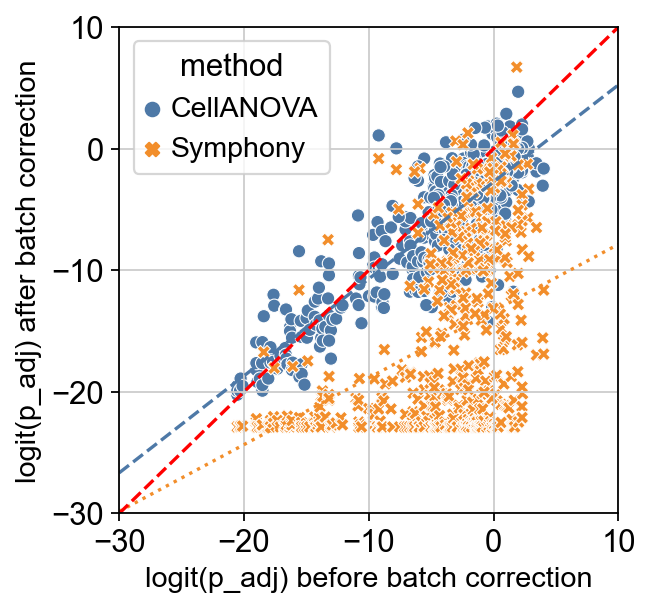

In [21]:
res1 = stats.linregress(df_finite[df_finite.method=='CellANOVA']['logit uncorrected pval'],
                        df_finite[df_finite.method=='CellANOVA']['logit corrected pval'])
res2 = stats.linregress(df_finite[df_finite.method=='Symphony']['logit uncorrected pval'],
                        df_finite[df_finite.method=='Symphony']['logit corrected pval'])
yvals = np.linspace(-30, 10)
line_1 = res1.slope * yvals + res1.intercept 
line_2 = res2.slope * yvals + res2.intercept 
p = sea.scatterplot(data=df_finite, x="logit uncorrected pval", y="logit corrected pval", 
                    hue="method", style = "method", legend=True, palette=["#4E79A7", "#F28E2B"])

plt.plot(yvals, line_1, "#4E79A7", label="Regression Line", linestyle = "dashed", antialiased=True)
plt.plot(yvals, line_2, "#F28E2B", label="Regression Line", linestyle = "dotted", antialiased=True)
plt.plot(yvals, yvals, 'r-', linewidth=1.5, linestyle = "dashed")
plt.xlim(-30, 10)
plt.ylim(-30, 10)
plt.xlabel('logit(p_adj) before batch correction', fontsize=13)
plt.ylabel('logit(p_adj) after batch correction', fontsize=13)
plt.show()